In [1]:
import numpy as np
import h5py
import json
import sys
sys.path.append('F:\Linux')
import illustris_python as il
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap


def xyline(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

# def LoadMergHist(simu, subhaloID):
#     '''
#     return subhalo's main progenitor and merger history with snapshot
#     '''
#     if simu == 'TNG':
#         ldir = '/Raid0/zhouzb/merg_data/tng_DiskMerTree/%d.json' % subhaloID
#     else:
#         ldir = '/Raid0/zhouzb/merg_data/il1_DiskMerTree/%d.json' % subhaloID
    
#     with open(ldir) as f:
#         data = json.load(f)
    
#     Main = np.array(data['Main'])
#     return dict(zip(Main[:, 0], Main[:, 1])), np.array(data['Mergers'])

def LoadMergHist(simu, subhaloID):
    '''
    return subhalo's main progenitor and merger history with snapshot
    '''
    if simu == 'TNG':
        ldir = 'f:/Linux/localRUN/tng_DiskMerTree/%d.json' % subhaloID
    else:
        ldir = 'f:/Linux/localRUN/il1_DiskMerTree/%d.json' % subhaloID
    
    with open(ldir) as f:
        data = json.load(f)
    
    Main = np.array(data['Main'])
    return dict(zip(Main[:, 0], Main[:, 1])), np.array(data['Mergers'])


In [113]:
def HistValAndBin(nums, bins, more=0, mask=0):
    if mask == 1:
        reMask = []

    val = []
    tmp = nums[nums < bins[1]]
    if mask == 1:
        reMask.append(nums < bins[1])
    val.append(len(tmp))

    for i in range(1,len(bins)-1):
        tmp = nums[(nums > bins[i]) & (nums <= bins[i+1])]
        val.append(len(tmp))
        if mask == 1:
            reMask.append((nums > bins[i]) & (nums <= bins[i+1]))

    if more == 1:
        tmp = nums[nums > bins[-1]]
        val.append(len(tmp))
        if mask == 1:
            reMask.append(nums > bins[-1])

    if mask == 0:
        return np.array(val)
    else:
        return np.array(val), np.array(reMask)

In [3]:

'''
snap_135 z=0
snap_127 z=0.1
snap_120 z=0.2
snap_113 z=0.31
snap_108 z=0.4
snap_103 z=0.5
snap_85 z=1.0
snap_75 z=1.53
snap_68 z=2.0
'''

il1_snapshot = [135, 127, 120, 113, 103, 108, 95, 85, 75, 68]
tng_snapshot = [99, 91, 84, 78, 72, 67, 59, 50, 40, 33]
Redshift = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0]

il1_GasFraction = {}
for snap in il1_snapshot:
    mas = il.func.loadSubhalos('il1', snap, 'SubhaloMassInHalfRadType')
    Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
    Gf[np.isnan(Gf)] = 0
    il1_GasFraction[snap] = Gf
    
tng_GasFraction = {}
for snap in tng_snapshot:
    mas = il.func.loadSubhalos('TNG', snap, 'SubhaloMassInHalfRadType')
    Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
    Gf[np.isnan(Gf)] = 0
    tng_GasFraction[snap] = Gf
    
tng2il1 = np.load('F:/Linux/localRUN/Match/tng2il1_allsub.npy',allow_pickle=1).item()
A2list = np.load('f:/Linux/localRUN/il1_A2withRedshift.npy',allow_pickle=1).item()

bar2bar = np.load('F:/npy/bar2bar.npy',allow_pickle=1).item()
bar2disk = np.load('f:/npy/bar2no.npy',allow_pickle=1).item()

il1_barID = np.load('f:/Linux/localRUN/barredID_il1.npy')
il1_diskID = np.load('f:/Linux/localRUN/diskID_il1.npy')

tng_barID = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy')
tng_diskID = np.load('f:/Linux/localRUN/diskID_4WP.npy')

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


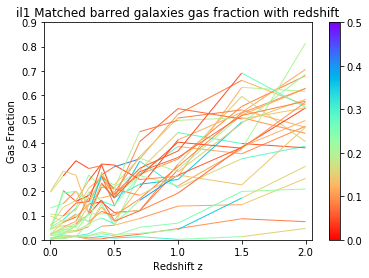

In [12]:
def il1_b2bGFwithZ():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    norm = plt.Normalize(0, 0.5)
    ax.set_xlim(-0.05, 2.05)
    ax.set_ylim(0, 0.9)
    ax.set_xlabel('Redshift z')
    ax.set_ylabel('Gas Fraction')
    ax.set_title('il1 Matched barred galaxies gas fraction with redshift')

    for subhaloID in bar2bar.values():
        # if GasFraction[33][subhaloID] < 0.25:
        #     continue
        prog = LoadMergHist('il1', subhaloID)[0]
        GFlist = []
        A2 = A2list[subhaloID]
        for snapnum in il1_snapshot:
            try:
                haloID = prog[snapnum]
            except:
                GFlist.append(-1)
                continue
            GFlist.append(il1_GasFraction[snapnum][haloID])

        xaxis = []
        yaxis = []
        color = []
        for i in range(10):
            if GFlist[i] != -1:
                xaxis.append(Redshift[i])
                yaxis.append(GFlist[i])
                color.append(float(A2[i]))

        seg = xyline(xaxis, yaxis)
        lc = LineCollection(seg, cmap='rainbow_r', norm=norm)
        lc.set_array(np.array(color))
        lc.set_linewidth(1)
        line = ax.add_collection(lc)
    fig.colorbar(line, ax=ax)
# plt.savefig('f:/Linux/local_result/Match/bar2bar/il1_barred_GF.png',dpi=400)

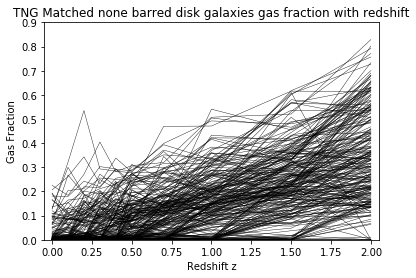

In [17]:
def TNG_nobarGFwithZ():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    norm = plt.Normalize(0, 0.5)
    ax.set_xlim(-0.05, 2.05)
    ax.set_ylim(0, 0.9)
    ax.set_xlabel('Redshift z')
    ax.set_ylabel('Gas Fraction')
    ax.set_title('TNG Matched none barred disk galaxies gas fraction with redshift')
    
    for subhaloID in bar2disk.keys():
        prog = LoadMergHist('TNG', subhaloID)[0]
        GFlist = []
        for snapnum in tng_snapshot:
            try:
                haloID = prog[snapnum]
            except:
                GFlist.append(-1)
                continue
            GFlist.append(tng_GasFraction[snapnum][haloID])

        xaxis = []
        yaxis = []
        for i in range(10):
            if GFlist[i] != -1:
                xaxis.append(Redshift[i])
                yaxis.append(GFlist[i])
        if len(xaxis) != 10:
            continue

        ax.plot(xaxis, yaxis, c='k', linewidth=0.4)

TNG_nobarGFwithZ()

0


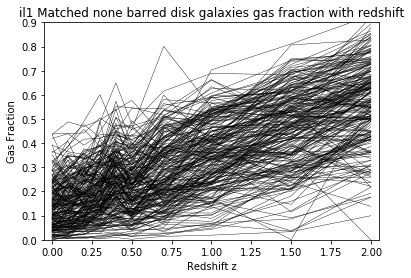

In [14]:
def il1_nobarGFwithZ():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    norm = plt.Normalize(0, 0.5)
    ax.set_xlim(-0.05, 2.05)
    ax.set_ylim(0, 0.9)
    ax.set_xlabel('Redshift z')
    ax.set_ylabel('Gas Fraction')
    ax.set_title('il1 Matched none barred disk galaxies gas fraction with redshift')

    for subhaloID in bar2disk.values():
        prog = LoadMergHist('il1', subhaloID)[0]
        GFlist = []
        for snapnum in il1_snapshot:
            try:
                haloID = prog[snapnum]
            except:
                GFlist.append(-1)
                continue
            GFlist.append(il1_GasFraction[snapnum][haloID])

        xaxis = []
        yaxis = []
        for i in range(10):
            if GFlist[i] != -1:
                xaxis.append(Redshift[i])
                yaxis.append(GFlist[i])
        if len(xaxis) != 10:
            continue

        ax.plot(xaxis, yaxis, c='k', linewidth=0.4)
    
il1_nobarGFwithZ()

In [98]:
tng_BHMass = {}
for snap in tng_snapshot:
    BH = il.func.loadSubhalos('TNG', snap, 'SubhaloBHMass')
    BH = np.log10(BH * 10**10) / 0.6774 
    BH[np.isneginf(BH)] = 0
    tng_BHMass[snap] = BH

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


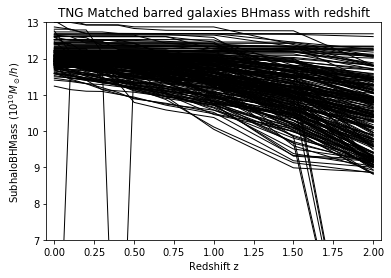

In [102]:
def TNG_nobarBHwithZ():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    norm = plt.Normalize(0, 0.5)
    ax.set_xlim(-0.05, 2.05)
    ax.set_ylim(7, 13)
    ax.set_xlabel('Redshift z')
    ax.set_ylabel(r'SubhaloBHMass ($10^{10} M_\odot/h$)')
    ax.set_title('TNG Matched barred galaxies BHmass with redshift')
    
    for subhaloID in bar2disk.keys():
        prog = LoadMergHist('TNG', subhaloID)[0]
        BHlist = []
        for snapnum in tng_snapshot:
            try:
                haloID = prog[snapnum]
            except:
                BHlist.append(-1)
                continue
            BHlist.append(tng_BHMass[snapnum][haloID])

        xaxis = []
        yaxis = []
        for i in range(10):
            if BHlist[i] != -1:
                xaxis.append(Redshift[i])
                yaxis.append(BHlist[i])
#         print(yaxis)

        ax.plot(xaxis, yaxis, c='k', linewidth=1)
#     plt.savefig('F:/Linux/local_result/Match/bar2disk/tng_BHMwithZ.png',dpi=400)
#     plt.savefig('F:/Linux/local_result/alldisk/tng_BHMwithZ.png',dpi=300)

TNG_nobarBHwithZ()

In [103]:
il1_BHMass = {}
for snap in il1_snapshot:
    BH = il.func.loadSubhalos('il1', snap, 'SubhaloBHMass')
#     BH = np.log10(BH * 10**10) / 0.704 
#     BH[np.isnan(BH)] = 0
#     BH[np.isneginf(BH)] = 0
    
    il1_BHMass[snap] = BH

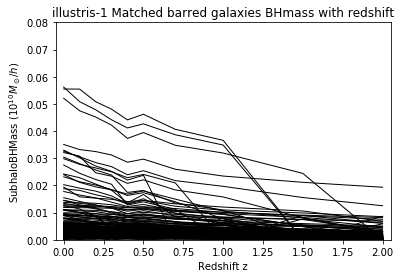

In [105]:
def il1_nobarBHwithZ():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    norm = plt.Normalize(0, 0.5)
    ax.set_xlim(-0.05, 2.05)
    ax.set_ylim(0, 0.08)
    ax.set_xlabel('Redshift z')
    ax.set_ylabel(r'SubhaloBHMass ($10^{10} M_\odot/h$)')
    ax.set_title('illustris-1 Matched barred galaxies BHmass with redshift')
    
    for subhaloID in bar2disk.values():
        if subhaloID == 215567:
            continue
        prog = LoadMergHist('il1', subhaloID)[0]
        BHlist = []
        for snapnum in il1_snapshot:
            try:
                haloID = prog[snapnum]
            except:
                BHlist.append(-1)
                continue
            BHlist.append(il1_BHMass[snapnum][haloID])

        xaxis = []
        yaxis = []
        if BHlist[0] > 0.09:
            continue
        for i in range(10):
            if BHlist[i] != -1:
                xaxis.append(Redshift[i])
                yaxis.append(BHlist[i])
       

        ax.plot(xaxis, yaxis, c='k', linewidth=1)
#     plt.savefig('F:/Linux/local_result/alldisk/il1_BHMwithZ.png',dpi=300)
    plt.savefig('F:/Linux/local_result/Match/bar2disk/il1_BHMwithZ.png',dpi=400)
    
il1_nobarBHwithZ()

In [62]:
bar2bar.values()

dict_values([215567, 239606, 265345, 310062, 305507, 308748, 307309, 321637, 335004, 351433, 353174, 339201, 344358, 351336, 352408, 359184, 358890, 372290, 371865, 382757, 369938, 383284, 378583, 396250, 387765, 390300, 408152])

In [94]:
def b2bCompairPlot():
    for subhaloID in bar2disk.keys():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        norm = plt.Normalize(0, 0.5)
        ax.set_xlim(-0.05, 2.05)
    #     ax.set_ylim(0, 0.09)
        ax.set_xlabel('Redshift z')
        ax.set_ylabel(r'SubhaloBHMass ($10^{10} M_\odot/h$)')
        ax.set_title('TNG & illustris-1 Matched barred galaxies BHmass with redshift')
    
    
    
        tng_prog = LoadMergHist('TNG', subhaloID)[0]
        il1_prog = LoadMergHist('il1', bar2disk[subhaloID])[0]
        tng_BHlist = []
        il1_BHlist = []
        
        for snapnum in tng_snapshot:
            haloID = tng_prog[snapnum]
            tng_BHlist.append(tng_BHMass[snapnum][haloID])
            
        for snapnum in il1_snapshot:
            haloID = il1_prog[snapnum]
            il1_BHlist.append(il1_BHMass[snapnum][haloID])
            
        tng_yaxis = []
        il1_yaxis = []
        for i in range(10):
            tng_yaxis.append(tng_BHlist[i])
            il1_yaxis.append(il1_BHlist[i])
#         if c == 0:
        ax.plot(Redshift, tng_yaxis, c='c', linewidth=1, label='TNG barred galaxies')
        ax.plot(Redshift, il1_yaxis, c='r', linewidth=1, label='illustris-1 barred galaxies')
#             c+=1
#         else:
#             ax.plot(Redshift, tng_yaxis, c='c', linewidth=1)
#             ax.plot(Redshift, il1_yaxis, c='r', linewidth=1)
        ax.legend(loc=1)
        plt.savefig('F:/Linux/local_result/Match/bar2bar/tmp/b2disk/%d.png'%subhaloID, dpi=400)
        plt.close()
    
b2bCompairPlot()

In [ ]:
def TNG_nobarBHwithZ():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    norm = plt.Normalize(0, 0.5)
    ax.set_xlim(-0.05, 2.05)
    ax.set_ylim(7, 13)
    ax.set_xlabel('Redshift z')
    ax.set_ylabel(r'SubhaloBHMass ($10^{10} M_\odot/h$)')
    ax.set_title('TNG Matched barred galaxies BHmass with redshift')
    
    for subhaloID in bar2disk.keys():
        prog = LoadMergHist('TNG', subhaloID)[0]
        BHlist = []
        for snapnum in tng_snapshot:
            try:
                haloID = prog[snapnum]
            except:
                BHlist.append(-1)
                continue
            BHlist.append(tng_BHMass[snapnum][haloID])

        xaxis = []
        yaxis = []
        for i in range(10):
            if BHlist[i] != -1:
                xaxis.append(Redshift[i])
                yaxis.append(BHlist[i])
#         print(yaxis)

        ax.plot(xaxis, yaxis, c='k', linewidth=1)
#     plt.savefig('F:/Linux/local_result/Match/bar2disk/tng_BHMwithZ.png',dpi=400)
#     plt.savefig('F:/Linux/local_result/alldisk/tng_BHMwithZ.png',dpi=300)

TNG_nobarBHwithZ()

In [156]:
il1_a2 = np.load('f:/Linux/localRUN/il1DiskA2withZ.npy',allow_pickle=1).item()
tng_a2 = np.load('f:/Linux/localRUN/tngDiskA2withZ.npy',allow_pickle=1).item()

In [157]:
tng_a2.keys()

dict_keys([67, 50, 40, 33, 99])

In [158]:
bins = np.linspace(0.15, 0.55,9)
il1_rs = [135, 103, 85, 68]
tng_rs = [99, 67, 50, 33]

In [159]:
il1_barFraction = {}
for snap in il1_rs:
    barred = []
    for a2 in il1_a2[snap].values():
        if(a2 >= 0.15):
            barred.append(a2)
    nums = HistValAndBin(np.array(barred), bins, more=1)
    il1_barFraction[snap] = nums / len(il1_a2[snap].values())
    
    

In [160]:
il1_barFraction

{135: array([0.05357143, 0.03246753, 0.01542208, 0.00487013, 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 103: array([0.07640879, 0.05921681, 0.02483286, 0.01241643, 0.00573066,
        0.00191022, 0.00095511, 0.        , 0.        ]),
 85: array([0.10444178, 0.08283313, 0.04801921, 0.01320528, 0.00960384,
        0.        , 0.        , 0.        , 0.        ]),
 68: array([0.17159763, 0.11538462, 0.06213018, 0.03846154, 0.02071006,
        0.00295858, 0.        , 0.        , 0.        ])}

In [124]:
for snap in il1_a2.keys():
    print(len(il1_a2[snap].values()))


1047
833
599
338


In [186]:
il1_tmp = {}
for snap in il1_barFraction.keys():
    ll = []
    for i in range(len(il1_barFraction[snap])):
        ll.append(sum(il1_barFraction[snap][i:-1]))
    il1_tmp[snap] = ll

In [187]:
il1_tmp

{135: [0.10633116883116882,
  0.052759740259740256,
  0.020292207792207792,
  0.00487012987012987,
  0.0,
  0.0,
  0.0,
  0.0,
  0],
 103: [0.18147086914995222,
  0.10506208213944603,
  0.04584527220630373,
  0.02101241642788921,
  0.008595988538681949,
  0.0028653295128939827,
  0.0009551098376313276,
  0.0,
  0],
 85: [0.2581032412965186,
  0.15366146458583432,
  0.07082833133253301,
  0.022809123649459785,
  0.009603841536614645,
  0.0,
  0.0,
  0.0,
  0],
 68: [0.41124260355029585,
  0.23964497041420119,
  0.12426035502958581,
  0.062130177514792904,
  0.02366863905325444,
  0.0029585798816568047,
  0.0,
  0.0,
  0]}

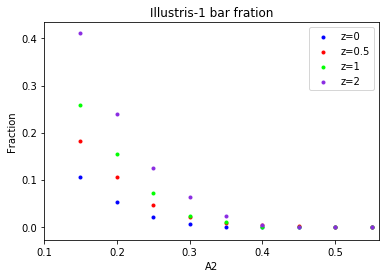

In [189]:

plt.scatter(bins, il1_tmp[135], color='b', label = 'z=0', marker='.')
plt.scatter(bins, il1_tmp[103], color='r', label = 'z=0.5', marker='.')
plt.scatter(bins, il1_tmp[85], color='lime', label = 'z=1', marker='.')
plt.scatter(bins, il1_tmp[68], color='blueviolet', label = 'z=2', marker='.')
plt.xlabel('A2')
plt.ylabel('Fraction')
plt.xlim(0.1,0.56)
plt.title('Illustris-1 bar fration')
plt.legend()
plt.savefig('F:/Linux/local_result/il1_SUM_barFrationWithZ.png',dpi=300)

In [174]:
tng_barFraction = {}
for snap in tng_rs:
    barred = []
    for a2 in tng_a2[snap].values():
        if(a2 >= 0.15):
            barred.append(a2)
    nums = HistValAndBin(np.array(barred), bins, more=1)
    tng_barFraction[snap] = nums / len(tng_a2[snap].values())
    

In [192]:
tng_tmp = {}
for snap in tng_barFraction.keys():
    ll = []
    for i in range(len(tng_barFraction[snap])):
        ll.append(sum(tng_barFraction[snap][i:-1]))
    tng_tmp[snap] = ll

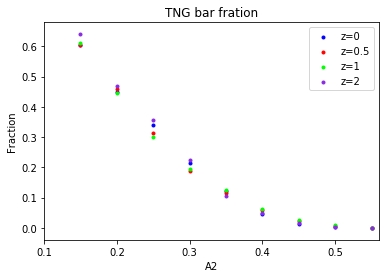

In [194]:

plt.scatter(bins, tng_tmp[99], color='b', label = 'z=0', marker='.')
plt.scatter(bins, tng_tmp[67], color='r', label = 'z=0.5', marker='.')
plt.scatter(bins, tng_tmp[50], color='lime', label = 'z=1', marker='.')
plt.scatter(bins, tng_tmp[33], color='blueviolet', label = 'z=2', marker='.')
plt.xlabel('A2')
plt.ylabel('Fraction')
plt.xlim(0.1,0.56)
plt.title('TNG bar fration')
plt.legend()
plt.savefig('F:/Linux/local_result/TNG__sum_barFrationWithZ.png',dpi=300)

In [126]:
'SubhaloBHMdot'
tng_BHdot = {}
for snap in tng_snapshot:
    BH = il.func.loadSubhalos('TNG', snap, 'SubhaloBHMdot')
    tng_BHdot[snap] = BH
    
il1_BHdot = {}
for snap in il1_snapshot:
    BH = il.func.loadSubhalos('il1', snap, 'SubhaloBHMdot')
    il1_BHdot[snap] = BH

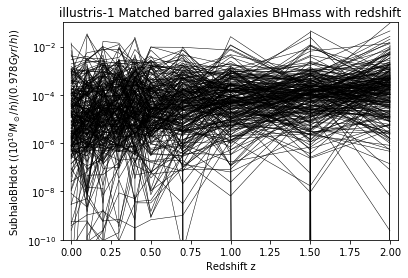

In [199]:
def il1_nobarBHdotwithZ():
    c=0
    fig = plt.figure()
    ax = fig.add_subplot(111)
    norm = plt.Normalize(0, 0.5)
    ax.set_xlim(-0.05, 2.05)
    ax.set_ylim(1e-10, 1e-1)
    ax.set_yscale("log")
    ax.set_xlabel('Redshift z')
    ax.set_ylabel(r'SubhaloBHdot ($(10^{10} M_\odot/h) / (0.978Gyr/h)$)')
    ax.set_title('illustris-1 Matched barred galaxies BHmass with redshift')
    
    for subhaloID in bar2disk.values():
        prog = LoadMergHist('il1', subhaloID)[0]
        BHlist = []
        for snapnum in il1_snapshot:
            try:
                haloID = prog[snapnum]
            except:
                BHlist.append(-1)
                continue
            BHlist.append(il1_BHdot[snapnum][haloID])
            

        xaxis = []
        yaxis = []

        
#         print(BHlist)
           
        for i in range(10):
            if BHlist[i] != -1:
                xaxis.append(Redshift[i])
                yaxis.append(BHlist[i])
       

        ax.plot(xaxis, yaxis, c='k', linewidth=0.5)
#     plt.savefig('F:/Linux/local_result/alldisk/il1_BHMwithZ.png',dpi=300)
    plt.savefig('F:/Linux/local_result/Match/bar2disk/il1_BHdotwithZ_log.png',dpi=400)
    
il1_nobarBHdotwithZ()

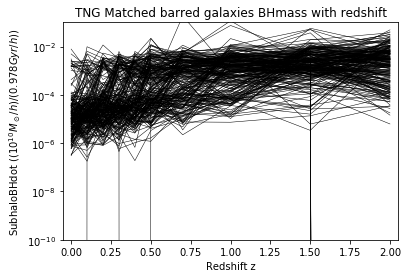

In [200]:
def TNG_nobarBHdotwithZ():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    norm = plt.Normalize(0, 0.5)
    ax.set_xlim(-0.05, 2.05)
    ax.set_ylim(1e-10, 1e-1)
    ax.set_yscale("log")
    ax.set_xlabel('Redshift z')
    ax.set_ylabel(r'SubhaloBHdot ($(10^{10} M_\odot/h) / (0.978Gyr/h)$)')
    ax.set_title('TNG Matched barred galaxies BHmass with redshift')
    
    for subhaloID in bar2disk.keys():
        prog = LoadMergHist('TNG', subhaloID)[0]
        BHlist = []
        for snapnum in tng_snapshot:
            try:
                haloID = prog[snapnum]
            except:
                BHlist.append(-1)
                continue
            BHlist.append(tng_BHdot[snapnum][haloID])

        xaxis = []
        yaxis = []

        for i in range(10):
            if BHlist[i] != -1:
                xaxis.append(Redshift[i])
                yaxis.append(BHlist[i])
       

        ax.plot(xaxis, yaxis, c='k', linewidth=0.5)
#     plt.savefig('F:/Linux/local_result/alldisk/il1_BHMwithZ.png',dpi=300)
    plt.savefig('F:/Linux/local_result/Match/bar2disk/TNG_BHdotwithZ_log.png',dpi=400)
    
TNG_nobarBHdotwithZ()